In [3]:
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# GMM clustering libraries
# import sys
# sys.path.insert(0, '../../libraries/')

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
from bnpgmm_runjingdev import utils_lib

# BNP libraries: these are pip installed
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib
import bnpmodeling_runjingdev.modeling_lib as modeling_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import json 

import time

# Load data

We load and plot the iris dataset

In [4]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

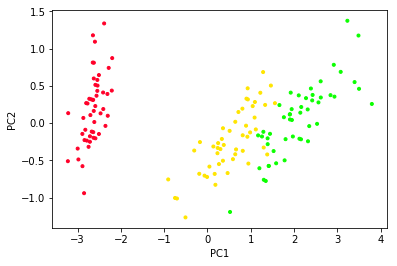

In [5]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [7]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = 3.5
print(prior_params_dict)

{'alpha': 3.5, 'prior_gamma_df': array([8.]), 'prior_centroid_info': array([0.1]), 'prior_centroid_mean': array([0.]), 'prior_gamma_inv_scale': array([[0.62, 0.  , 0.  , 0.  ],
       [0.  , 0.62, 0.  , 0.  ],
       [0.  , 0.  , 0.62, 0.  ],
       [0.  , 0.  , 0.  , 0.62]])}


### Variational parameters

In [8]:
# number of clusters in variational distribution 
k_approx = 30

In [9]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [10]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [11]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1460.205125758913

# Optimize the KL objective

### Initialize with k-means

In [12]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                  seed = 453453)

gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights)

450.9718947107098

### Set up KL objective 

In [13]:
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl,
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_loss = \
    lambda x : get_vb_params_loss(features,
                                x, prior_params_dict,
                                 gh_loc, gh_weights)


In [14]:
# # get loss as a function of vb parameters
# get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
# get_vb_params_loss.cache_args(features, None, prior_params_dict,
#                                 gh_loc, gh_weights)

# # Get loss as a function vb_free_params
# get_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
#                                         patterns=vb_params_paragami,
#                                         free=True)


In [15]:
t0 = time.time()
vb_opt = optimization_lib.optimize_full(get_loss, init_vb_free_params,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

refit_time = time.time() - t0

running bfgs ... 
Iter 0: f = 450.97189471
Iter 1: f = 288.42252948
Iter 2: f = 132.82724910
Iter 3: f = 849.69522338
Iter 4: f = 102.95800124
Iter 5: f = 69.15077895
Iter 6: f = 35.10598280
Iter 7: f = 149.86270237
Iter 8: f = 27.90810015
Iter 9: f = 15.66532676
Iter 10: f = -4.96037757
Iter 11: f = -35.63242473
Iter 12: f = -69.57876702
Iter 13: f = -106.48627732
Iter 14: f = -109.56137218
Iter 15: f = -129.49640794
Iter 16: f = -148.49222218
Iter 17: f = -180.42498864
Iter 18: f = -183.90475287
Iter 19: f = -197.82029664
Iter 20: f = -223.21611941
Iter 21: f = -210.67850230
Iter 22: f = -233.90999359
Iter 23: f = -248.01428698
Iter 24: f = -266.50049101
Iter 25: f = -275.43483870
Iter 26: f = -288.85589805
Iter 27: f = -294.21119573
Iter 28: f = -301.02567169
Iter 29: f = -309.37688825
Iter 30: f = -321.41152123
Iter 31: f = -317.57546051
Iter 32: f = -326.55252540
Iter 33: f = -332.95619469
Iter 34: f = -339.92264168
Iter 35: f = -342.52883975
Iter 36: f = -346.68395276
Iter 37: f 

In [16]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

In [17]:
# plot check results
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

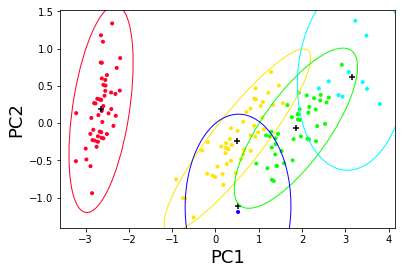

In [18]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [22]:
paragami.save_folded('./iris_fits/iris_fits_alpha{}'.format(prior_params_dict['alpha']), 
                     vb_opt_dict,
                     vb_params_paragami, 
                     alpha = prior_params_dict['alpha'], 
                    gh_deg = gh_deg, 
                    refit_time = refit_time)

# Fit for a range of alpha 

In [23]:
alpha_list = np.arange(start=0.5, stop=16, step=0.5)

print(alpha_list)

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.
 14.5 15.  15.5]


In [24]:
def refit_with_alpha(alpha, vb_opt): 
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # set up new objective, witht the prior changed
#     get_vb_params_loss.cache_args(features, None, prior_params_pert_dict, gh_loc, gh_weights)
#     get_pert_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
#                                             patterns=vb_params_paragami,
#                                             free=True)

    get_vb_params_loss = paragami.FlattenFunctionInput(
                                    original_fun=gmm_lib.get_kl,
                                    patterns = vb_params_paragami,
                                    free = True,
                                    argnums = 1)

    get_pert_loss = \
        lambda x : get_vb_params_loss(features,
                                    x, prior_params_pert_dict,
                                     gh_loc, gh_weights)

    vb_opt_pert = optimization_lib.optimize_full(get_pert_loss,deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    return vb_opt_pert

In [25]:
for alpha in alpha_list: 
    print('######################')
    print('re-optimzing with alpha = ', alpha)
    print('######################')
    
    t0 = time.time() 
    
    vb_opt_pert = refit_with_alpha(alpha, vb_opt)
    
    vb_pert_dict = vb_params_paragami.fold(vb_opt_pert, free = True)
    
    refit_time = time.time() - t0
    print('refit time: {:.03f}sec'.format(refit_time))
    
    filename = './iris_fits/iris_fits_alpha{}'.format(alpha)
    print('saving results to ', filename)
    paragami.save_folded(filename, 
                     vb_pert_dict,
                     vb_params_paragami, 
                     alpha = alpha, 
                    gh_deg = gh_deg, 
                    refit_time = refit_time)
    


######################
re-optimzing with alpha =  0.5
######################
running bfgs ... 
Iter 0: f = -403.98026666
Iter 1: f = -406.58768253
Iter 2: f = -373.34681958
Iter 3: f = -406.77111301
Iter 4: f = -407.08967003
Iter 5: f = -407.69241418
Iter 6: f = -408.45943579
Iter 7: f = -409.25613796
Iter 8: f = -410.24149998
Iter 9: f = -411.00134242
Iter 10: f = -411.89994779
Iter 11: f = -412.18271817
Iter 12: f = -412.70278181
Iter 13: f = -413.63742997
Iter 14: f = -414.45832852
Iter 15: f = -415.93155096
Iter 16: f = -417.05817664
Iter 17: f = -418.96393667
Iter 18: f = -417.36117619
Iter 19: f = -419.68141679
Iter 20: f = -420.59364344
Iter 21: f = -422.04833433
Iter 22: f = -424.06494277
Iter 23: f = -426.23117028
Iter 24: f = -423.98757964
Iter 25: f = -426.95801117
Iter 26: f = -427.78330726
Iter 27: f = -428.79122678
Iter 28: f = -428.35371997
Iter 29: f = -429.20308447
Iter 30: f = -429.72293990
Iter 31: f = -429.36597514
Iter 32: f = -429.92098237
Iter 33: f = -429.928793

Iter 4: f = -400.68723386
Iter 5: f = -401.09016228
Iter 6: f = -401.57313651
Iter 7: f = -402.05249075
Iter 8: f = -402.64346278
Iter 9: f = -403.07387766
Iter 10: f = -403.57638110
Iter 11: f = -403.70546110
Iter 12: f = -403.94705883
Iter 13: f = -404.38767801
Iter 14: f = -404.83662672
Iter 15: f = -405.62022334
Iter 16: f = -406.28136972
Iter 17: f = -407.32200009
Iter 18: f = -406.32777353
Iter 19: f = -407.69109255
Iter 20: f = -408.09228672
Iter 21: f = -408.78853658
Iter 22: f = -409.71461047
Iter 23: f = -410.58947334
Iter 24: f = -410.49676717
Iter 25: f = -411.00191595
Iter 26: f = -410.90702928
Iter 27: f = -411.18591650
Iter 28: f = -411.46535780
Iter 29: f = -411.58233791
Iter 30: f = -411.75520787
Iter 31: f = -411.76162794
Iter 32: f = -411.84451723
Iter 33: f = -411.97803652
Iter 34: f = -412.08365768
Iter 35: f = -412.25888169
Iter 36: f = -412.28567366
Iter 37: f = -412.30777792
Iter 38: f = -412.34698401
Iter 39: f = -412.38934089
Iter 40: f = -412.45159567
Iter 41

Iter 104: f = -400.57379918
Iter 105: f = -400.57379918
Iter 106: f = -400.57379918
Iter 107: f = -400.57379918
Iter 108: f = -400.57379918
Iter 109: f = -400.57379918
Iter 110: f = -400.57379918
Iter 111: f = -400.57379918
Iter 112: f = -400.57379918
Iter 113: f = -400.57379918
Iter 114: f = -400.57379918
Iter 115: f = -400.57379918
Iter 116: f = -400.57379918
Iter 117: f = -400.57379918
Iter 118: f = -400.57379918
Iter 119: f = -400.57379918
Iter 120: f = -400.57379918
Iter 121: f = -400.57379918
Iter 122: f = -400.57379918
Iter 123: f = -400.57379918
Iter 124: f = -400.57379918
Iter 125: f = -400.57379918
Iter 126: f = -400.57379918
Iter 127: f = -400.57379918
Iter 128: f = -400.57379918
Iter 129: f = -400.57379918
Iter 130: f = -400.57379918
Iter 131: f = -400.57379918
Iter 132: f = -400.57379918
Iter 133: f = -400.57379918
Iter 134: f = -400.57379918
Iter 135: f = -400.57379918
Iter 136: f = -400.57379918
Iter 137: f = -400.57379918
Iter 138: f = -400.57379918
Iter 139: f = -400.5

Iter 119: f = -391.45687279
Iter 120: f = -391.45687279
Iter 121: f = -391.45687279
Iter 122: f = -391.45687279
Iter 123: f = -391.45687279
Iter 124: f = -391.45687279
Iter 125: f = -391.45687279
Iter 126: f = -391.45687279
Iter 127: f = -391.45687279
Iter 128: f = -391.45687279
Iter 129: f = -391.45687279
Iter 130: f = -391.45687279
Iter 131: f = -391.45687279
Iter 132: f = -391.45687279
Iter 133: f = -391.45687279
Iter 134: f = -391.45687279
Iter 135: f = -391.45687279
Iter 136: f = -391.45687279
Iter 137: f = -391.45687279
Iter 138: f = -391.45687279
Iter 139: f = -391.45687279
Iter 140: f = -391.45687279
Iter 141: f = -391.45687279
Iter 142: f = -391.45687279
Iter 143: f = -391.45687279
Iter 144: f = -391.45687279
Iter 145: f = -391.45687279
Iter 146: f = -391.45687279
Iter 147: f = -391.45687279
Iter 148: f = -391.45687279
Iter 149: f = -391.45687279
Iter 150: f = -391.45687279
Iter 151: f = -391.45687279
Iter 152: f = -391.45687279
Iter 153: f = -391.45687279
Iter 154: f = -391.4

Iter 8: f = -377.37159795
Iter 9: f = -377.38588977
Iter 10: f = -377.39694264
Iter 11: f = -377.40791103
Iter 12: f = -377.41619190
Iter 13: f = -377.42984904
Iter 14: f = -377.44909813
Iter 15: f = -377.44779685
Iter 16: f = -377.45850163
Iter 17: f = -377.47308723
Iter 18: f = -377.47924217
Iter 19: f = -377.48931762
Iter 20: f = -377.49281138
Iter 21: f = -377.49914935
Iter 22: f = -377.51004232
Iter 23: f = -377.52594627
Iter 24: f = -377.49710976
Iter 25: f = -377.53016649
Iter 26: f = -377.53386229
Iter 27: f = -377.53874491
Iter 28: f = -377.54518671
Iter 29: f = -377.55167269
Iter 30: f = -377.54694186
Iter 31: f = -377.55408237
Iter 32: f = -377.55709297
Iter 33: f = -377.56019839
Iter 34: f = -377.56325255
Iter 35: f = -377.56501995
Iter 36: f = -377.53738768
Iter 37: f = -377.56512170
Iter 38: f = -377.56529398
Iter 39: f = -377.56558176
Iter 40: f = -377.56594057
Iter 41: f = -377.56584256
Iter 42: f = -377.56610012
Iter 43: f = -377.56638837
Iter 44: f = -377.56547713
Ite

Iter 48: f = -366.82660106
Iter 49: f = -366.82899104
Iter 50: f = -366.82909426
Iter 51: f = -366.82926838
Iter 52: f = -366.82946022
Iter 53: f = -366.82881573
Iter 54: f = -366.82949654
Iter 55: f = -366.82956565
Iter 56: f = -366.82969051
Iter 57: f = -366.82989651
Iter 58: f = -366.83013184
Iter 59: f = -366.83022433
Iter 60: f = -366.83033625
Iter 61: f = -366.83041812
Iter 62: f = -366.83047367
Iter 63: f = -366.83052600
Iter 64: f = -366.83055231
Iter 65: f = -366.83057505
Iter 66: f = -366.83058165
Iter 67: f = -366.83059128
Iter 68: f = -366.83059439
Iter 69: f = -366.83059911
Iter 70: f = -366.83060382
Iter 71: f = -366.83060300
Iter 72: f = -366.83060601
Iter 73: f = -366.83060694
Iter 74: f = -366.83060838
Iter 75: f = -366.83060981
Iter 76: f = -366.83061004
Iter 77: f = -366.83061042
Iter 78: f = -366.83061088
Iter 79: f = -366.83061109
Iter 80: f = -366.83061119
Iter 81: f = -366.83061131
Iter 82: f = -366.83061126
Iter 83: f = -366.83061137
Iter 84: f = -366.83061142
I

preconditioning time: 13.10
running newton steps
Iter 0: f = -362.19054994
Iter 1: f = -362.19054994
Optimization terminated successfully.
         Current function value: -362.190550
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 2
Iter 0: x_diff = 3.424467044554879e-05, f_diff = 5.684341886080802e-14, grad_l1 = 8.827835134259726e-11
done. 
refit time: 22.821sec
saving results to  ./iris_fits/iris_fits_alpha4.5
######################
re-optimzing with alpha =  5.0
######################
running bfgs ... 
Iter 0: f = -355.88279216
Iter 1: f = -355.47206397
Iter 2: f = -356.43067465
Iter 3: f = -347.97505340
Iter 4: f = -356.46261456
Iter 5: f = -356.51781014
Iter 6: f = -356.61847876
Iter 7: f = -356.69192515
Iter 8: f = -356.76307071
Iter 9: f = -356.85883828
Iter 10: f = -356.92862113
Iter 11: f = -356.98569526
Iter 12: f = -357.05655620
Iter 13: f = -357.16414334
Iter 14: f = -357.27229162
Iter 15: f = -357.2918

Iter 124: f = -353.92469699
Iter 125: f = -353.92469699
Iter 126: f = -353.92469699
Iter 127: f = -353.92469699
Iter 128: f = -353.92469699
Iter 129: f = -353.92469699
Iter 130: f = -353.92469699
Iter 131: f = -353.92469699
Iter 132: f = -353.92469699
Iter 133: f = -353.92469699
Iter 134: f = -353.92469699
Iter 135: f = -353.92469699
Iter 136: f = -353.92469699
Iter 137: f = -353.92469699
Iter 138: f = -353.92469699
Iter 139: f = -353.92469699
Iter 140: f = -353.92469699
Iter 141: f = -353.92469699
Iter 142: f = -353.92469699
Iter 143: f = -353.92469699
Iter 144: f = -353.92469699
Iter 145: f = -353.92469699
Iter 146: f = -353.92469699
Iter 147: f = -353.92469699
Iter 148: f = -353.92469699
Iter 149: f = -353.92469699
Iter 150: f = -353.92469699
Iter 151: f = -353.92469699
Iter 152: f = -353.92469699
Iter 153: f = -353.92469699
Iter 154: f = -353.92469699
Iter 155: f = -353.92469699
Iter 156: f = -353.92469699
Iter 157: f = -353.92469699
Iter 158: f = -353.92469699
Iter 159: f = -353.9

Iter 61: f = -346.67435660
Iter 62: f = -346.67595047
Iter 63: f = -346.67664857
Iter 64: f = -346.67703379
Iter 65: f = -346.67738572
Iter 66: f = -346.67768447
Iter 67: f = -346.67771939
Iter 68: f = -346.67778382
Iter 69: f = -346.67789802
Iter 70: f = -346.67805432
Iter 71: f = -346.67811621
Iter 72: f = -346.67816056
Iter 73: f = -346.67819777
Iter 74: f = -346.67815137
Iter 75: f = -346.67820804
Iter 76: f = -346.67821956
Iter 77: f = -346.67822545
Iter 78: f = -346.67823394
Iter 79: f = -346.67823463
Iter 80: f = -346.67823840
Iter 81: f = -346.67824011
Iter 82: f = -346.67824143
Iter 83: f = -346.67824272
Iter 84: f = -346.67824222
Iter 85: f = -346.67824296
Iter 86: f = -346.67824327
Iter 87: f = -346.67824342
Iter 88: f = -346.67824363
Iter 89: f = -346.67824379
Iter 90: f = -346.67824350
Iter 91: f = -346.67824383
Iter 92: f = -346.67824388
Iter 93: f = -346.67824387
Iter 94: f = -346.67824390
Iter 95: f = -346.67824392
Iter 96: f = -346.67824392
Iter 97: f = -346.67824393
I

Iter 162: f = -343.35686900
Iter 163: f = -343.35686900
Iter 164: f = -343.35686900
Iter 165: f = -343.35686900
Iter 166: f = -343.35686900
Iter 167: f = -343.35686900
Iter 168: f = -343.35686900
Iter 169: f = -343.35686900
Iter 170: f = -343.35686900
Iter 171: f = -343.35686900
Iter 172: f = -343.35686900
Iter 173: f = -343.35686900
Iter 174: f = -343.35686900
Iter 175: f = -343.35686900
Iter 176: f = -343.35686900
Iter 177: f = -343.35686900
Iter 178: f = -343.35686900
Iter 179: f = -343.35686900
Iter 180: f = -343.35686900
Iter 181: f = -343.35686900
Iter 182: f = -343.35686900
Iter 183: f = -343.35686900
Iter 184: f = -343.35686900
Iter 185: f = -343.35686900
         Current function value: -343.356869
         Iterations: 102
         Function evaluations: 186
         Gradient evaluations: 174

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 10.62
running newton steps
Iter 0: f = -343.35686900
Iter 1: f = -343.35686900
Opti

Iter 4: f = -328.86285722
Iter 5: f = -329.61491461
Iter 6: f = -330.02192145
Iter 7: f = -330.45815834
Iter 8: f = -331.05970666
Iter 9: f = -331.46550093
Iter 10: f = -331.65083242
Iter 11: f = -331.96398405
Iter 12: f = -332.47336769
Iter 13: f = -332.89850448
Iter 14: f = -333.28896664
Iter 15: f = -333.77415217
Iter 16: f = -332.57519161
Iter 17: f = -333.88434354
Iter 18: f = -334.08329318
Iter 19: f = -334.34967575
Iter 20: f = -334.77244694
Iter 21: f = -335.34739210
Iter 22: f = -334.86359514
Iter 23: f = -335.55272371
Iter 24: f = -335.69985831
Iter 25: f = -335.83895340
Iter 26: f = -336.05399912
Iter 27: f = -336.38545175
Iter 28: f = -336.52892180
Iter 29: f = -336.36999740
Iter 30: f = -336.57619239
Iter 31: f = -336.62843191
Iter 32: f = -336.71507551
Iter 33: f = -336.68608987
Iter 34: f = -336.75251997
Iter 35: f = -336.80817127
Iter 36: f = -336.86878554
Iter 37: f = -336.96160593
Iter 38: f = -336.17959458
Iter 39: f = -336.97070042
Iter 40: f = -336.98548721
Iter 41

Iter 133: f = -334.34570964
Iter 134: f = -334.34570964
Iter 135: f = -334.34570964
Iter 136: f = -334.34570964
Iter 137: f = -334.34570964
Iter 138: f = -334.34570964
Iter 139: f = -334.34570964
Iter 140: f = -334.34570964
Iter 141: f = -334.34570964
Iter 142: f = -334.34570964
Iter 143: f = -334.34570964
Iter 144: f = -334.34570964
Iter 145: f = -334.34570964
Iter 146: f = -334.34570964
Iter 147: f = -334.34570964
Iter 148: f = -334.34570964
Iter 149: f = -334.34570964
Iter 150: f = -334.34570964
Iter 151: f = -334.34570964
Iter 152: f = -334.34570964
Iter 153: f = -334.34570964
Iter 154: f = -334.34570964
Iter 155: f = -334.34570964
Iter 156: f = -334.34570964
Iter 157: f = -334.34570964
Iter 158: f = -334.34570964
Iter 159: f = -334.34570964
Iter 160: f = -334.34570964
Iter 161: f = -334.34570964
Iter 162: f = -334.34570964
Iter 163: f = -334.34570964
Iter 164: f = -334.34570964
Iter 165: f = -334.34570964
Iter 166: f = -334.34570964
Iter 167: f = -334.34570964
Iter 168: f = -334.3

Iter 102: f = -331.60809879
Iter 103: f = -331.60809880
Iter 104: f = -331.60809881
Iter 105: f = -331.60809881
Iter 106: f = -331.60809882
Iter 107: f = -331.60809881
Iter 108: f = -331.60809882
Iter 109: f = -331.60809882
Iter 110: f = -331.60809882
Iter 111: f = -331.60809882
Iter 112: f = -331.60809882
Iter 113: f = -331.60809882
Iter 114: f = -331.60809882
Iter 115: f = -331.60809882
Iter 116: f = -331.60809882
Iter 117: f = -331.60809882
Iter 118: f = -331.60809882
Iter 119: f = -331.60809882
Iter 120: f = -331.60809882
Iter 121: f = -331.60809882
Iter 122: f = -331.60809882
Iter 123: f = -331.60809882
Iter 124: f = -331.60809882
Iter 125: f = -331.60809882
Iter 126: f = -331.60809882
Iter 127: f = -331.60809882
         Current function value: -331.608099
         Iterations: 104
         Function evaluations: 128
         Gradient evaluations: 127

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 10.33
running newton steps


Iter 242: f = -328.98413160
Iter 243: f = -328.98413160
Iter 244: f = -328.98413160
Iter 245: f = -328.98413160
Iter 246: f = -328.98413160
Iter 247: f = -328.98413160
Iter 248: f = -328.98413160
Iter 249: f = -328.98413160
Iter 250: f = -328.98413160
Iter 251: f = -328.98413160
Iter 252: f = -328.98413160
Iter 253: f = -328.98413160
Iter 254: f = -328.98413160
Iter 255: f = -328.98413160
Iter 256: f = -328.98413160
Iter 257: f = -328.98413160
Iter 258: f = -328.98413160
Iter 259: f = -328.98413160
Iter 260: f = -328.98413160
Iter 261: f = -328.98413160
Iter 262: f = -328.98413160
Iter 263: f = -328.98413160
Iter 264: f = -328.98413160
Iter 265: f = -328.98413160
Iter 266: f = -328.98413160
Iter 267: f = -328.98413160
Iter 268: f = -328.98413160
Iter 269: f = -328.98413160
Iter 270: f = -328.98413160
Iter 271: f = -328.98413160
Iter 272: f = -328.98413160
Iter 273: f = -328.98413160
         Current function value: -328.984132
         Iterations: 106
         Function evaluations: 274

Iter 8: f = -310.97710971
Iter 9: f = -311.77035824
Iter 10: f = -312.10021613
Iter 11: f = -312.66179388
Iter 12: f = -313.58764381
Iter 13: f = -314.34356956
Iter 14: f = -315.08207460
Iter 15: f = -316.00306824
Iter 16: f = -313.79550506
Iter 17: f = -316.21573026
Iter 18: f = -316.60235867
Iter 19: f = -317.15514649
Iter 20: f = -318.06777943
Iter 21: f = -319.26961955
Iter 22: f = -318.40882135
Iter 23: f = -319.71695684
Iter 24: f = -320.14172232
Iter 25: f = -320.65003234
Iter 26: f = -321.41342908
Iter 27: f = -322.34874997
Iter 28: f = -321.26307683
Iter 29: f = -322.64503804
Iter 30: f = -322.00620655
Iter 31: f = -322.71977219
Iter 32: f = -322.80860935
Iter 33: f = -322.95087242
Iter 34: f = -323.04595804
Iter 35: f = -323.18249373
Iter 36: f = -323.31289666
Iter 37: f = -323.49931320
Iter 38: f = -322.16942023
Iter 39: f = -323.52047256
Iter 40: f = -323.55121401
Iter 41: f = -323.59828436
Iter 42: f = -323.65861473
Iter 43: f = -323.65289800
Iter 44: f = -323.68793810
Ite

Iter 130: f = -321.71119474
Iter 131: f = -321.71119474
Iter 132: f = -321.71119474
Iter 133: f = -321.71119474
Iter 134: f = -321.71119474
Iter 135: f = -321.71119474
Iter 136: f = -321.71119474
Iter 137: f = -321.71119474
Iter 138: f = -321.71119474
Iter 139: f = -321.71119474
Iter 140: f = -321.71119474
Iter 141: f = -321.71119474
Iter 142: f = -321.71119474
Iter 143: f = -321.71119474
Iter 144: f = -321.71119474
Iter 145: f = -321.71119474
Iter 146: f = -321.71119474
Iter 147: f = -321.71119474
Iter 148: f = -321.71119474
Iter 149: f = -321.71119474
Iter 150: f = -321.71119474
Iter 151: f = -321.71119474
Iter 152: f = -321.71119474
Iter 153: f = -321.71119474
Iter 154: f = -321.71119474
Iter 155: f = -321.71119474
Iter 156: f = -321.71119474
Iter 157: f = -321.71119474
Iter 158: f = -321.71119474
Iter 159: f = -321.71119474
Iter 160: f = -321.71119474
Iter 161: f = -321.71119474
Iter 162: f = -321.71119474
Iter 163: f = -321.71119474
Iter 164: f = -321.71119474
Iter 165: f = -321.7

Iter 40: f = -316.33490870
Iter 41: f = -316.45819585
Iter 42: f = -316.59026941
Iter 43: f = -316.77020128
Iter 44: f = -316.48456814
Iter 45: f = -316.82197662
Iter 46: f = -316.90740138
Iter 47: f = -316.57134671
Iter 48: f = -316.92248999
Iter 49: f = -316.95083005
Iter 50: f = -316.99696813
Iter 51: f = -317.05146913
Iter 52: f = -317.09234364
Iter 53: f = -317.13109941
Iter 54: f = -317.11894792
Iter 55: f = -317.14826829
Iter 56: f = -317.17242408
Iter 57: f = -317.19634976
Iter 58: f = -317.22766523
Iter 59: f = -317.23112983
Iter 60: f = -317.24472848
Iter 61: f = -317.26380902
Iter 62: f = -317.25473008
Iter 63: f = -317.27161563
Iter 64: f = -317.28078186
Iter 65: f = -317.27668746
Iter 66: f = -317.28457495
Iter 67: f = -317.28912691
Iter 68: f = -317.28868203
Iter 69: f = -317.29133393
Iter 70: f = -317.29370595
Iter 71: f = -317.29453984
Iter 72: f = -317.29569927
Iter 73: f = -317.29686503
Iter 74: f = -317.29638557
Iter 75: f = -317.29735527
Iter 76: f = -317.29769629
I

Iter 343: f = -317.29851972
Iter 344: f = -317.29851972
Iter 345: f = -317.29851972
Iter 346: f = -317.29851972
Iter 347: f = -317.29851972
Iter 348: f = -317.29851972
Iter 349: f = -317.29851972
Iter 350: f = -317.29851972
Iter 351: f = -317.29851972
Iter 352: f = -317.29851972
Iter 353: f = -317.29851972
Iter 354: f = -317.29851972
Iter 355: f = -317.29851972
Iter 356: f = -317.29851972
Iter 357: f = -317.29851972
Iter 358: f = -317.29851972
Iter 359: f = -317.29851972
Iter 360: f = -317.29851972
Iter 361: f = -317.29851972
Iter 362: f = -317.29851972
Iter 363: f = -317.29851972
Iter 364: f = -317.29851972
Iter 365: f = -317.29851972
Iter 366: f = -317.29851972
Iter 367: f = -317.29851972
Iter 368: f = -317.29851972
Iter 369: f = -317.29851972
Iter 370: f = -317.29851972
Iter 371: f = -317.29851972
Iter 372: f = -317.29851972
Iter 373: f = -317.29851972
Iter 374: f = -317.29851972
Iter 375: f = -317.29851972
Iter 376: f = -317.29851972
Iter 377: f = -317.29851972
Iter 378: f = -317.2

Iter 4: f = -285.07008282
Iter 5: f = -287.66695147
Iter 6: f = -288.26627458
Iter 7: f = -289.18780181
Iter 8: f = -290.62144234
Iter 9: f = -291.90815085
Iter 10: f = -292.36713431
Iter 11: f = -293.15960894
Iter 12: f = -294.48904155
Iter 13: f = -295.60353364
Iter 14: f = -296.70997471
Iter 15: f = -298.15240857
Iter 16: f = -294.78037713
Iter 17: f = -298.49004113
Iter 18: f = -299.11019633
Iter 19: f = -300.04882563
Iter 20: f = -301.64633897
Iter 21: f = -303.66037753
Iter 22: f = -303.66807419
Iter 23: f = -304.68264777
Iter 24: f = -305.43252593
Iter 25: f = -306.56105782
Iter 26: f = -308.32172439
Iter 27: f = -308.61165409
Iter 28: f = -308.90712286
Iter 29: f = -309.06515405
Iter 30: f = -309.32213996
Iter 31: f = -309.75878351
Iter 32: f = -310.36621906
Iter 33: f = -311.16931978
Iter 34: f = -308.94578047
Iter 35: f = -311.33622865
Iter 36: f = -311.63332608
Iter 37: f = -311.51396096
Iter 38: f = -311.75787077
Iter 39: f = -311.94198719
Iter 40: f = -312.20211010
Iter 41

Iter 129: f = -311.24284166
Iter 130: f = -311.24284166
Iter 131: f = -311.24284166
Iter 132: f = -311.24284166
Iter 133: f = -311.24284166
Iter 134: f = -311.24284166
Iter 135: f = -311.24284166
Iter 136: f = -311.24284166
Iter 137: f = -311.24284166
Iter 138: f = -311.24284166
Iter 139: f = -311.24284166
Iter 140: f = -311.24284166
Iter 141: f = -311.24284166
Iter 142: f = -311.24284166
Iter 143: f = -311.24284166
Iter 144: f = -311.24284166
Iter 145: f = -311.24284166
Iter 146: f = -311.24284166
Iter 147: f = -311.24284166
Iter 148: f = -311.24284166
Iter 149: f = -311.24284166
Iter 150: f = -311.24284166
Iter 151: f = -311.24284166
Iter 152: f = -311.24284166
Iter 153: f = -311.24284166
Iter 154: f = -311.24284166
Iter 155: f = -311.24284166
Iter 156: f = -311.24284166
Iter 157: f = -311.24284166
Iter 158: f = -311.24284166
Iter 159: f = -311.24284166
Iter 160: f = -311.24284166
Iter 161: f = -311.24284166
Iter 162: f = -311.24284166
Iter 163: f = -311.24284166
Iter 164: f = -311.2

Iter 82: f = -309.36157494
Iter 83: f = -309.36155187
Iter 84: f = -309.36158802
Iter 85: f = -309.36159346
Iter 86: f = -309.36160042
Iter 87: f = -309.36160428
Iter 88: f = -309.36160746
Iter 89: f = -309.36160898
Iter 90: f = -309.36161023
Iter 91: f = -309.36161122
Iter 92: f = -309.36161130
Iter 93: f = -309.36161145
Iter 94: f = -309.36161173
Iter 95: f = -309.36161207
Iter 96: f = -309.36161238
Iter 97: f = -309.36161205
Iter 98: f = -309.36161242
Iter 99: f = -309.36161247
Iter 100: f = -309.36161247
Iter 101: f = -309.36161250
Iter 102: f = -309.36161253
Iter 103: f = -309.36161253
Iter 104: f = -309.36161254
Iter 105: f = -309.36161255
Iter 106: f = -309.36161255
Iter 107: f = -309.36161255
Iter 108: f = -309.36161256
Iter 109: f = -309.36161255
Iter 110: f = -309.36161256
Iter 111: f = -309.36161256
Iter 112: f = -309.36161256
Iter 113: f = -309.36161256
Iter 114: f = -309.36161256
Iter 115: f = -309.36161256
Iter 116: f = -309.36161256
Iter 117: f = -309.36161256
Iter 118: 

Iter 162: f = -307.54540613
Iter 163: f = -307.54540613
Iter 164: f = -307.54540613
Iter 165: f = -307.54540613
Iter 166: f = -307.54540613
Iter 167: f = -307.54540613
Iter 168: f = -307.54540613
Iter 169: f = -307.54540613
Iter 170: f = -307.54540613
Iter 171: f = -307.54540613
Iter 172: f = -307.54540613
Iter 173: f = -307.54540613
Iter 174: f = -307.54540613
Iter 175: f = -307.54540613
Iter 176: f = -307.54540613
Iter 177: f = -307.54540613
Iter 178: f = -307.54540613
Iter 179: f = -307.54540613
Iter 180: f = -307.54540613
Iter 181: f = -307.54540613
Iter 182: f = -307.54540613
Iter 183: f = -307.54540613
Iter 184: f = -307.54540613
Iter 185: f = -307.54540613
Iter 186: f = -307.54540613
         Current function value: -307.545406
         Iterations: 114
         Function evaluations: 187
         Gradient evaluations: 175

 running preconditioned newton; iter =  0
Computing Hessian to set preconditioner
preconditioning time: 10.28
running newton steps
Iter 0: f = -307.54540613
It

preconditioning time: 9.94
running newton steps
Iter 0: f = -305.79376484
Iter 1: f = -305.79376484
Optimization terminated successfully.
         Current function value: -305.793765
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 2
Iter 0: x_diff = 3.941039971206592e-05, f_diff = 6.821210263296962e-13, grad_l1 = 1.0858107249036063e-10
done. 
refit time: 18.731sec
saving results to  ./iris_fits/iris_fits_alpha15.0
######################
re-optimzing with alpha =  15.5
######################
running bfgs ... 
Iter 0: f = -243.65535165
Iter 1: f = -260.02207361
Iter 2: f = -140.98546743
Iter 3: f = -261.25302678
Iter 4: f = -263.36992458
Iter 5: f = -267.08166833
Iter 6: f = -267.37491989
Iter 7: f = -269.03343820
Iter 8: f = -270.66482529
Iter 9: f = -272.96614793
Iter 10: f = -274.51839328
Iter 11: f = -275.13718548
Iter 12: f = -276.19772556
Iter 13: f = -277.93645921
Iter 14: f = -279.40764680
Iter 15: f = -280.90

Optimization terminated successfully.
         Current function value: -304.185296
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 2
Iter 0: x_diff = 1.8637688845101136e-05, f_diff = 6.252776074688882e-13, grad_l1 = 1.2134792470816247e-10
done. 
refit time: 21.016sec
saving results to  ./iris_fits/iris_fits_alpha15.5


In [26]:
print('Done!')

Done!
